In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import re
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit
import numpy as np
import pandas as pd

import psytrack_learning as psy
from psytrack_learning.getMAP import getMAP
from psytrack_learning.helper.helperFunctions import update_hyper, hyper_to_list
from psytrack_learning.helper.jacHessCheck import compHess, compHess_nolog
from psytrack_learning.helper.invBlkTriDiag import getCredibleInterval
from psytrack_learning.hyperparameter_optimization import evd_lossfun
from psytrack_learning.learning_rules import RewardMax, PredictMax, REINFORCE, REINFORCE_base
from psytrack_learning.simulate_learning import reward_max, predict_max, reinforce, reinforce_base 
from psytrack_learning.simulate_learning import simulate_learning


# Set matplotlib defaults from making files editable and consistent in Illustrator
colors = psy.COLORS
zorder = psy.ZORDER
plt.rcParams['figure.dpi'] = 140
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.facecolor'] = (1,1,1,0)
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'cmu serif'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 12

# Set save path for all figures
spath = ""  # UPDATE
sim_colors = ["#D81159", "#4357AD", "#EE8434", "#CC3399", "#409091"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading Data

## Download and pre-process IBL mouse data

1) Download the [IBL dataset](https://doi.org/10.6084/m9.figshare.11636748.v7) (version 7, uploaded Feb 7, 2020).

2) Update the `ibl_data_path` variable below to where the `ibl-behavioral-data-Dec2019` directory exists on your computer.

In [3]:
ibl_data_path = '../ibl/ibl-behavioral-data-Dec2019/'  # --- UPDATE ---

In [4]:
ibl_data_path

'../ibl/ibl-behavioral-data-Dec2019/'

3) We will also need to install the [ONE Light](https://github.com/int-brain-lab/ibllib/tree/master/oneibl) Python library (from the IBL) with `pip install ibllib`. This allows us to build a table of all the subject and session data contained within the dataset.

In [6]:
import os
from oneibl.onelight import ONE
import pandas as pd

current_cwd = os.getcwd()
os.chdir(ibl_data_path)

# Search all sessions that have these dataset types.
required_vars = ['_ibl_trials.choice', '_ibl_trials.contrastLeft',
                 '_ibl_trials.contrastRight','_ibl_trials.feedbackType']
one = ONE()
eids = one.search(required_vars)

mouseData = pd.DataFrame()
for eid in eids:
    lab, _, subject, date, session = eid.split("/")    
    sess_vars = {
        "eid": eid,
        "lab": lab,
        "subject": subject,
        "date": date,
        "session": session,
    }
    mouseData = mouseData.append(sess_vars, sort=True, ignore_index=True)

os.chdir(current_cwd)

4) Next, we will use the table of session data to process the raw trial data below into a single CSV file, `ibl_processed.csv`, saved locally.

There are several known anomalies in the raw data:
 - CSHL_002 codes left contrasts as negative right contrasts on 81 trials (these trials are corrected)
 - ZM_1084 has `feedbackType` of 0 for 3 trials (these trials are omitted)
 - DY_009, DY_010, DY_011 each have <5000 trials total (no adjustment)
 - ZM_1367, ZM_1369, ZM_1371, ZM_1372, and ZM_1743 are shown non-standard contrast values of 0.04 and 0.08 (no adjustment)

_2 min_

In [7]:
all_vars = ["contrastLeft", "contrastRight", "choice", "feedbackType", "probabilityLeft"]
df = pd.DataFrame()

all_mice = []
for j, s in enumerate(mouseData["subject"].unique()):
    print("\rProcessing " + str(j+1) + " of " + str(len(mouseData["subject"].unique())), end="")
    mouse = mouseData[mouseData["subject"]==s].sort_values(['date', 'session']).reset_index()
    for i, row in mouse.iterrows():
        myVars = {}
        for v in all_vars:
            filename = "_ibl_trials." + v + ".npy"
            var_file = os.path.join(ibl_data_path, row.eid, "alf", filename)
            myVars[v] = list(np.load(var_file).flatten())

        num_trials = len(myVars[v])
        myVars['lab'] = [row.lab]*num_trials
        myVars['subject'] = [row.subject]*num_trials
        myVars['date'] = [row.date]*num_trials
        myVars['session'] = [row.session]*num_trials

        all_mice += [pd.DataFrame(myVars, columns=myVars.keys())]
        
df = pd.concat(all_mice, ignore_index=True)

df = df[df['choice'] != 0]        # dump mistrials
df = df[df['feedbackType'] != 0]  # 3 anomalous trials from ZM_1084, omit
df.loc[np.isnan(df['contrastLeft']), "contrastLeft"] = 0
df.loc[np.isnan(df['contrastRight']), "contrastRight"] = 0
df.loc[df["contrastRight"] < 0, "contrastLeft"] = np.abs(df.loc[df["contrastRight"] < 0, "contrastRight"])
df.loc[df["contrastRight"] < 0, "contrastRight"] = 0  # 81 anomalous trials in CSHL_002, correct
df["answer"] = df["feedbackType"] * df["choice"]      # new column to indicate correct answer
df.loc[df["answer"]==1, "answer"] = 0
df.loc[df["answer"]==-1, "answer"] = 1
df.loc[df["feedbackType"]==-1, "feedbackType"] = 0
df.loc[df["choice"]==1, "choice"] = 0
df.loc[df["choice"]==-1, "choice"] = 1


Processing 101 of 101

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nicholasroy/ActiveLearningPapers/NeurIPS20/Figures/FigureComponents/ibl_processed.csv'

In [11]:
df.to_csv(spath+"ibl_processed.csv", index=False)

In [12]:
df.head()

,contrastLeft,contrastRight,choice,feedbackType,probabilityLeft,lab,subject,date,session,answer
1,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,001,0
2,1.0,0.0,1,0,1.0,angelakilab,IBL-T1,2019-02-09,001,0
3,0.0,1.0,1,1,1.0,angelakilab,IBL-T1,2019-02-09,001,1
4,0.5,0.0,0,1,0.5,angelakilab,IBL-T1,2019-02-09,001,0
7,0.5,0.0,0,1,0.9,angelakilab,IBL-T1,2019-02-09,001,0


5) Next we do a few sanity checks on our data, to make sure everything processed correctly.

In [13]:
print("contrastLeft: ", np.unique(df['contrastLeft']))   # [0, 0.0625, 0.125, 0.25, 0.5, 1.0] and [0.04, 0.08]
print("contrastRight: ", np.unique(df['contrastRight'])) # [0, 0.0625, 0.125, 0.25, 0.5, 1.0] and [0.04, 0.08]
print("choice: ", np.unique(df['choice']))               # [0, 1]
print("feedbackType: ", np.unique(df['feedbackType']))   # [0, 1]
print("answer: ", np.unique(df['answer']))               # [0, 1]

contrastLeft:  [0.     0.04   0.0625 0.08   0.125  0.25   0.5    1.    ]
contrastRight:  [0.     0.04   0.0625 0.08   0.125  0.25   0.5    1.    ]
choice:  [0 1]
feedbackType:  [0 1]
answer:  [0 1]


6) Finally, we define a function `getMouse()` that extracts the data for a single mouse from our CSV file, and returns it in a PsyTrack compatible dictionary. We will use this function to access IBL mouse data in the figures below. Note the keyword argument and default value $p=5$ which controls the strength of the $\tanh$ transformation on the contrast values. See Figure S3 and the STAR Methods for more details.

**Note:** Once steps 1-6 have been run once, only step 6 will need to be run on subsequent uses.

In [14]:
mouse_data_path = spath + "ibl_processed.csv"   # --- UPDATE if necessary ---
MOUSE_DF = pd.read_csv(mouse_data_path)

def getMouse(subject, p=5):
    df = MOUSE_DF[MOUSE_DF['subject']==subject]   # Restrict data to the subject specified
    
    cL = np.tanh(p*df['contrastLeft'])/np.tanh(p)   # tanh transformation of left contrasts
    cR = np.tanh(p*df['contrastRight'])/np.tanh(p)  # tanh transformation of right contrasts
    cBoth = cR - cL
    inputs = dict(cL = np.array(cL)[:, None], cR = np.array(cR)[:, None], cBoth = np.array(cBoth)[:, None])

    dat = dict(
        subject=subject,
        lab=np.unique(df["lab"])[0],
        contrastLeft=np.array(df['contrastLeft']),
        contrastRight=np.array(df['contrastRight']),
        date=np.array(df['date']),
        dayLength=np.array(df.groupby(['date','session']).size()),
        correct=np.array(df['feedbackType']),
        answer=np.array(df['answer']),
        probL=np.array(df['probabilityLeft']),
        inputs = inputs,
        y = np.array(df['choice'])
    )
    
    return dat

---

## Athena Rat Data

You can download the processed IBL data as a CSV file, `rat_behavior.csv`, from [here](https://drive.google.com/drive/u/0/folders/1eOfqq3ijdWLxvhumFioJ3LgNmLZdrBtq).
Next, update the `rat_data_path` below to where the CSV file is locally saved.
You can the use the `getRat` function below to extract the data for a single subject into a PsyTrack compatible dict.

Note that mistrials have been omitted, as have sessions from before the reward rule was enforced (i.e. shaping sessions). The `getRat` function also has two optional parameters: `first` which will return a data set with only the first `first` trials (20,000 seems reasonable for our purposes); `cutoff` excludes sessions with fewer than `cutoff` valid trials (currently set to 50).

In [ ]:
rat_data_path = "~/rat_behavior.csv"   # --- UPDATE ---
RAT_DF = pd.read_csv(rat_data_path)

RAT_DF = RAT_DF[RAT_DF["training_stage"] > 2]  # Remove trials from early training
RAT_DF = RAT_DF[~np.isnan(RAT_DF["choice"])]   # Remove mistrials

def getRat(subject, first=20000, cutoff=50):

    df = RAT_DF[RAT_DF['subject_id']==subject]  # restrict dataset to single subject
    df = df[:first]  # restrict to "first" trials of data
    # remove sessions with fewer than "cutoff" valid trials
    df = df.groupby('session').filter(lambda x: len(x) >= cutoff)   

    # Normalize the stimuli to standard normal
    s_a = (df["s_a"] - np.mean(df["s_a"]))/np.std(df["s_a"])
    s_b = (df["s_b"] - np.mean(df["s_b"]))/np.std(df["s_b"])
    
    # Determine which trials do not have a valid previous trial (mistrial or session boundary)
    t = np.array(df["trial"])
    prior = ((t[1:] - t[:-1]) == 1).astype(int)
    prior = np.hstack(([0], prior))

    # Calculate previous average tone value
    s_avg = (df["s_a"][:-1] + df["s_b"][:-1])/2
    s_avg = (s_avg - np.mean(s_avg))/np.std(s_avg)
    s_avg = np.hstack(([0], s_avg))
    s_avg = s_avg * prior  # for trials without a valid previous trial, set to 0

    # Calculate previous correct answer
    h = (df["correct_side"][:-1] * 2 - 1).astype(int)   # map from (0,1) to (-1,1)
    h = np.hstack(([0], h))
    h = h * prior  # for trials without a valid previous trial, set to 0
    
    # Calculate previous choice
    c = (df["choice"][:-1] * 2 - 1).astype(int)   # map from (0,1) to (-1,1)
    c = np.hstack(([0], c))
    c = c * prior  # for trials without a valid previous trial, set to 0
    
    inputs = dict(s_a = np.array(s_a)[:, None],
                  s_b = np.array(s_b)[:, None],
                  s_avg = np.array(s_avg)[:, None],
                  h = np.array(h)[:, None],
                  c = np.array(c)[:, None])

    dat = dict(
        subject = subject,
        inputs = inputs,
        s_a = np.array(df['s_a']),
        s_b = np.array(df['s_b']),
        correct = np.array(df['hit']),
        answer = np.array(df['correct_side']),
        y = np.array(df['choice']),
        dayLength=np.array(df.groupby(['session']).size()),
    )
    return dat

---

# Figure 2 | REINFORCE Simulation

In [ ]:
### Set up
N = 10000  # would like to work with ~6000 trials, should try

seed = 20  # 20
print("Seed:", seed)
np.random.seed(seed)

# Simulate sequence of contrasts directly (instead of grabbing from real mouse)
p=5
contrasts = np.array([0.0625, 0.125, 0.25, 0.5, 1.0])  # full set of contrasts
tanh_contrasts = np.tanh(p*contrasts)/np.tanh(p)  # tanh transform
all_contrasts = np.hstack((-tanh_contrasts[::-1], [0], tanh_contrasts))  # left contrasts are neg

contrast_seq = np.random.choice(all_contrasts, size=N) # generate random sequence
answer = np.sign(contrast_seq).astype(int)  # infer answers for each trial
answer[answer==0] = np.sign(np.random.randn(np.sum(answer==0)))  # randomly select answer for 0 contrast
answer[answer<0] = 0

# Build data set from simulated data
weights = {"bias": 1, "cBoth": 1}
dat = {'inputs': {'cBoth': contrast_seq.reshape(-1,1)}, 'answer': answer, 'y': np.zeros(N)}
X = psy.read_input(dat, weights)
K = np.sum([i for i in weights.values()])

# Set true parameters of weight trajectory simulation
true_sigma  = 2**np.array([-9.0, -9.0])  # -5, -6
true_alpha  = 2**np.array([-6.0, -7.0])  # -6, -7
true_base  = np.array([0.4, -0.2])  # -0.15, 0.1, careful about which parametrization is being used
true_hyper = {
    'adder': true_base,
    'alpha': true_alpha,
    'sigma': true_sigma,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

sim_learning_rule = reinforce_base  # learning rule used in generation of weights
rec_learning_rule = REINFORCE_base  # learning rule used for recovery of weights

# Simulate the weight trajectories, also returning choices and rewards
W, y, r, sim_noise = simulate_learning(X=X, answer=answer, sigma=true_sigma, sigma0=1, seed=seed,
                                       alpha=true_alpha, base=true_base/true_alpha, # NOTE
                                       learning_rule=sim_learning_rule)

dat.update({"y": y, "correct": r})
gen_dat = {"dat": dat, 'true_sigma': true_sigma, 'true_alpha': true_alpha, 'true_base': true_base,
           "weights": weights, "K": K,
           'sim_learning_rule': sim_learning_rule.__name__, "rec_learning_rule": rec_learning_rule.__name__,
           "W": W, "sim_noise": sim_noise, "seed": seed}
np.savez_compressed(spath+'FigN2_data.npz', gen_dat=gen_dat)


# Display simulated weights, broken up into learning/nosie components
fig = psy.plot_weights(W, weights)

noise_sim = np.cumsum(gen_dat['sim_noise'].T, axis=1)
learning_sim = gen_dat['W'] - noise_sim

fig = plt.figure(figsize=(3.25,1.25))
sim_colors = [colors['bias'], colors['cBoth']]
for i, c in enumerate(sim_colors):
    plt.plot(learning_sim[i], c=c, lw=1, linestyle='-', alpha=0.75, zorder=1)
    plt.plot(noise_sim[i], c=c, lw=0.5, linestyle='--', alpha=0.5, zorder=2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 


# Calculate evdience under true hyper
wMode_true, _, logEvd, _ = getMAP(dat, true_hyper, weights, W0=None,
                         learning_rule=rec_learning_rule, showOpt=0, tol=1e-12)
print("True Evidence:", logEvd)
fig = psy.plot_weights(wMode_true.reshape(K,-1), weights)


In [67]:
### For Athena Task + example rat
N = 5000
seed = 42
mouse_name = "CSHL_003"
np.random.seed(seed)

orig_dat = getMouse(mouse_name, 5)
trim_dat = psy.trim(orig_dat, END=N)

weights = {"bias": 1, "cBoth": 1}
K = np.sum([i for i in weights.values()])
X = psy.read_input(trim_dat, weights)
answer = trim_dat["answer"]
true_sigma  = 2**np.array([-4.0, -5.0])
true_alpha  = 2**np.array([-6.0, -8.0])
sim_learning_rule = reinforce
rec_learning_rule = REINFORCE

W, y, r, sim_noise = simulate_learning(X=X, answer=answer, sigma=true_sigma, sigma0=1,
                                       alpha=true_alpha, learning_rule=sim_learning_rule)


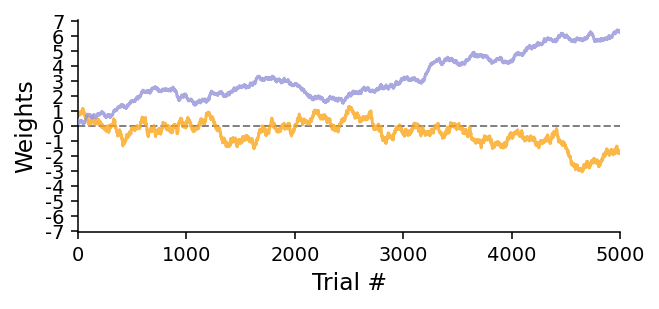

In [69]:
rec_learning_rule = REINFORCE
dat = {'inputs': trim_dat['inputs'].copy(), 'y': y, 'answer': answer, "correct": r}
gen_dat = {"dat": dat, 'true_sigma': true_sigma, 'true_alpha': true_alpha, "weights": weights, "K": K,
           'sim_learning_rule': sim_learning_rule, "rec_learning_rule": rec_learning_rule,
           "W": W, "sim_noise": sim_noise, "seed": seed}

fig = psy.plot_weights(W, weights)
# np.savez_compressed(spath+'fig2a_data_gen.npz', gen_dat=gen_dat)

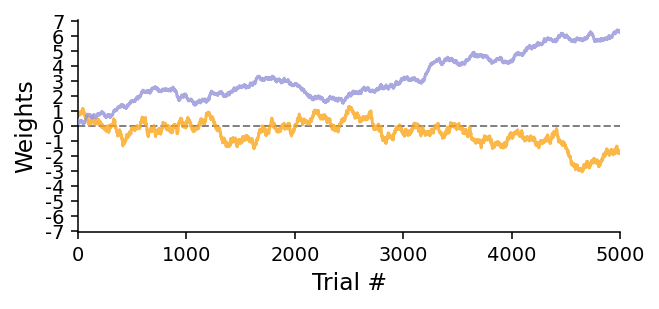

In [70]:
rec_learning_rule = REINFORCE
dat = {'inputs': trim_dat['inputs'].copy(), 'y': y, 'answer': answer, "correct": r}
gen_dat = {"dat": dat, 'true_sigma': true_sigma, 'true_alpha': true_alpha, "weights": weights, "K": K,
           'sim_learning_rule': sim_learning_rule, "rec_learning_rule": rec_learning_rule,
           "W": W, "sim_noise": sim_noise, "seed": seed}

fig = psy.plot_weights(W, weights)
# np.savez_compressed(spath+'fig2a_data_gen.npz', gen_dat=gen_dat)

In [71]:
# Compute
hyper_guess = {
    'alpha': [2**-6] * K,
    'sigma': [2**-4] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for both sigma and alpha simultaneously
optList = ['sigma', 'alpha']

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": dat, "K": K, "learning_rule": rec_learning_rule,
        "hyper": hyper_guess, "weights": weights, "update_w": True, "wMode": None,
        "tol": 1e-8, "showOpt": True,
       }

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA')
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)
wMode_sim2, Hess, logEvd, other = getMAP(dat, opt_hyper, weights, W0=None,
                                         learning_rule=rec_learning_rule, showOpt=0, tol=1e-12)
# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)
wMode_sim2 = wMode_sim2.reshape((K, -1), order="C")

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, "W_std": W_std, "wMode": wMode_sim2}

# np.savez_compressed(spath+'fig2a_data_rec.npz', rec_dat=rec_dat)

    [-4. -4. -6. -6.] 1 1271.473 
    [-3. -4. -6. -6.] 2 1279.302 
    [-4. -3. -6. -6.] 3 1285.044 
    [-4. -4. -5. -6.] 4 1270.879 
    [-4. -4. -5. -5.] 5 1271.565 
    [-4.499 -4.865 -4.962 -6.044] 6 1270.455 
    [-4.94  -4.635 -4.929 -6.082] 7 1273.516 
    [-4.477 -4.865 -4.962 -6.293] 8 1270.235 
    [-4.063 -5.139 -4.915 -6.327] 9 1269.809 
    [-3.894 -5.397 -4.689 -6.649] 10 1271.456 
    [-4.166 -5.318 -5.055 -6.336] 11 1271.076 
    [-3.765 -4.799 -5.128 -6.344] 12 1269.246 
    [-3.62  -4.68  -4.915 -5.932] 13 1269.614 
    [-3.637 -4.618 -4.815 -6.664] 14 1269.646 
    [-3.644 -4.838 -5.341 -6.373] 15 1270.047 
    [-3.943 -4.629 -5.171 -6.33 ] 16 1268.804 
    [-4.165 -4.707 -5.089 -6.318] 17 1268.895 
    [-3.947 -4.62  -5.158 -6.454] 18 1268.854 
    [-3.926 -4.443 -5.012 -6.28 ] 19 1268.949 
    [-3.981 -4.575 -5.276 -6.317] 20 1268.883 
    [-3.94  -4.58  -5.135 -6.317] 21 1268.808 
    [-3.913 -4.624 -5.179 -6.332] 22 1268.843 
    [-3.982 -4.659 -5.139 -6.31 ] 2

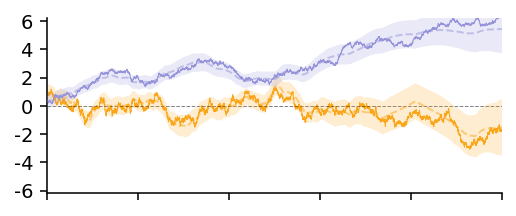

In [72]:
# Reload data
# rec_dat = np.load(spath+'fig2a_data_rec.npz', allow_pickle=True)['rec_dat'].item()
# gen_dat = np.load(spath+'fig2a_data_gen.npz', allow_pickle=True)['gen_dat'].item()

# Plotting
fig = plt.figure(figsize=(3.25,1.25))
sim_colors = [colors['bias'], colors['h']]

for i, c in enumerate(sim_colors):
    plt.plot(gen_dat['W'][i], c=c, lw=0.5, zorder=2*i)
    plt.plot(rec_dat['wMode'][i], c=c, lw=1, linestyle='--', alpha=0.5, zorder=2*i+1)
    plt.fill_between(np.arange(len(rec_dat['wMode'][i])),
                     rec_dat['wMode'][i] - 2 * rec_dat['W_std'][i],
                     rec_dat['wMode'][i] + 2 * rec_dat['W_std'][i],
                     facecolor=c, alpha=0.2, zorder=2*i+1)

plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)

plt.gca().set_xticklabels([])
plt.yticks(np.arange(-6,7,2))
plt.xlim(0,5000); plt.ylim(-6.2,6.2)
# plt.xlabel("Trials"); plt.ylabel("Weights")

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 
# plt.savefig(spath + "Fig2a.pdf")

In [73]:
# Recover error bars for hyperparameters
# rec_dat = np.load(spath+'fig2a_data_rec.npz', allow_pickle=True)['rec_dat'].item()
hess_args = rec_dat['args'].copy()
hess_args["wMode"] = rec_dat['wMode'].flatten()
hess_args["learning_rule"] = hess_args["learning_rule"]
H, g = compHess_nolog(evd_lossfun, rec_dat['res'].x, 5e-2, {"keywords": hess_args})
hyp_std = np.sqrt(np.diag(np.linalg.inv(H)))

rec_dat['hyp_std'] = hyp_std
# np.savez_compressed(spath+'fig2a_data_rec.npz', rec_dat=rec_dat)

    [-3.933 -4.661 -4.408 -6.158] 131 1268.43 
    [-3.863 -4.661 -4.408 -6.158] 132 1268.465 
    [-4.007 -4.661 -4.408 -6.158] 133 1268.468 
    [-3.933 -4.591 -4.408 -6.158] 134 1268.457 
    [-3.933 -4.735 -4.408 -6.158] 135 1268.459 
    [-3.933 -4.661 -4.337 -6.158] 136 1268.435 
    [-3.933 -4.661 -4.482 -6.158] 137 1268.435 
    [-3.933 -4.661 -4.408 -6.088] 138 1268.436 
    [-3.933 -4.661 -4.408 -6.232] 139 1268.436 
    [-3.898 -4.626 -4.408 -6.158] 140 1268.445 
    [-3.97  -4.698 -4.408 -6.158] 141 1268.446 
    [-3.898 -4.698 -4.408 -6.158] 142 1268.446 
    [-3.97  -4.626 -4.408 -6.158] 143 1268.447 
    [-3.898 -4.661 -4.372 -6.158] 144 1268.437 
    [-3.97  -4.661 -4.444 -6.158] 145 1268.438 
    [-3.898 -4.661 -4.444 -6.158] 146 1268.443 
    [-3.97  -4.661 -4.372 -6.158] 147 1268.443 
    [-3.898 -4.661 -4.408 -6.122] 148 1268.44 
    [-3.97  -4.661 -4.408 -6.195] 149 1268.44 
    [-3.898 -4.661 -4.408 -6.195] 150 1268.441 
    [-3.97  -4.661 -4.408 -6.122] 151 1268.

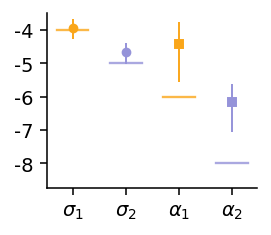

In [74]:
# Reload data
# rec_dat = np.load(spath+'fig2a_data_rec.npz', allow_pickle=True)['rec_dat'].item()
# gen_dat = np.load(spath+'fig2a_data_gen.npz', allow_pickle=True)['gen_dat'].item()

# Plot recovered hyperparameters
plt.figure(figsize=(1.5,1.25))
sim_colors = [colors['bias'], colors['h']]
num_std = 1.00
K = gen_dat['K']

true_sigma = gen_dat['true_sigma']
avg_sigma = np.log2(rec_dat['opt_hyper']['sigma'])
err_sigma = rec_dat['hyp_std'][:K]
for i, c in enumerate(sim_colors):
    yerr = [[-(np.log2(2**avg_sigma[i] - err_sigma[i]*num_std) - avg_sigma[i])],
            [np.log2(2**avg_sigma[i] + err_sigma[i]*num_std) - avg_sigma[i]]]
    if np.isnan(yerr[0][0]):
        yerr[0][0] = 100
    plt.plot([i-0.3, i+0.3], [np.log2(true_sigma[i])]*2, color=c, linestyle="-", lw=1.2, zorder=1, alpha=0.8)
    plt.errorbar([i], avg_sigma[i], yerr=yerr, c=c, lw=1, marker='o', markersize=4)
    
true_alpha = gen_dat['true_alpha']
avg_alpha = np.log2(rec_dat['opt_hyper']['alpha'])
err_alpha = rec_dat['hyp_std'][K:2*K]
for i, c in enumerate(sim_colors):
    yerr = [[-(np.log2(2**avg_alpha[i] - err_alpha[i]*num_std) - avg_alpha[i])],
            [np.log2(2**avg_alpha[i] + err_alpha[i]*num_std) - avg_alpha[i]]]
    if np.isnan(yerr[0][0]):
        yerr[0][0] = 100
    plt.plot([i+1.7, i+2.3], [np.log2(true_alpha[i])]*2, color=c, linestyle="-", lw=1.2, zorder=1, alpha=0.8)
    plt.errorbar([i+2], avg_alpha[i], yerr=yerr, c=c, lw=1, marker='s', markersize=4)
    
plt.ylim(-8.75,-3.5)
plt.yticks(np.arange(-8,-3))
plt.xticks([0,1,2,3])
plt.gca().set_xticklabels([r"$\sigma_1$", r"$\sigma_2$",
                           r"$\alpha_1$", r"$\alpha_2$"])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 
# plt.savefig(spath + "Fig2b.pdf")

In [75]:
# rec_dat = np.load(spath+'fig2a_data_rec.npz', allow_pickle=True)['rec_dat'].item()
# gen_dat = np.load(spath+'fig2a_data_gen.npz', allow_pickle=True)['gen_dat'].item()

wMode, Hess, logEvd, other = getMAP(gen_dat['dat'], rec_dat['opt_hyper'], gen_dat['weights'], W0=None,
                                    learning_rule=gen_dat['rec_learning_rule'], showOpt=0, tol=1e-12)
wMode = wMode.reshape((gen_dat['K'], -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((gen_dat['K'], -1), order="C")

<ipython-input-76-7ad267e84fb1>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([0,1000,2000,3000,4000,5000])


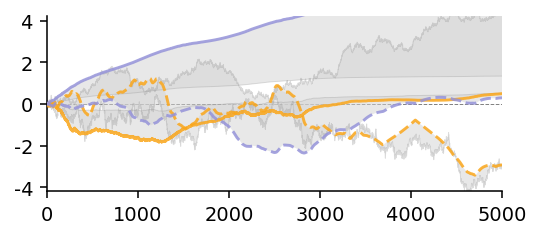

In [76]:
noise = np.cumsum(E_rw, axis=1)
learning = np.cumsum(v_rw, axis=1)
noise_sim = np.cumsum(gen_dat['sim_noise'].T, axis=1)
learning_sim = gen_dat['W'] - noise_sim

fig = plt.figure(figsize=(3.25,1.25))
sim_colors = [colors['bias'], colors['cBoth']]

for i, c in enumerate(sim_colors):
    plt.plot(learning[i], c=c, lw=1.5, linestyle='-', alpha=0.85, zorder=10+2*i)
    plt.plot(noise[i] - noise[i, 0], c=c, lw=1.5, linestyle='--', alpha=0.85, zorder=10+2*i+1)
    plt.plot(learning_sim[i], c="gray", lw=0.5, linestyle='-', alpha=0.25, zorder=2)
    plt.plot(noise_sim[i] - noise_sim[i, 0], c="gray", lw=0.5, linestyle='-', alpha=0.25, zorder=2)
    plt.fill_between(np.arange(len(noise[i])),
                     learning[i], learning_sim[i],
                     facecolor="lightgray", alpha=0.5, zorder=1)
    plt.fill_between(np.arange(len(noise[i])),
                     noise[i] - noise[i, 0], noise_sim[i] - noise_sim[i, 0],
                     facecolor="lightgray", alpha=0.5, zorder=1)

plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)

plt.gca().set_xticklabels([0,1000,2000,3000,4000,5000])
plt.yticks(np.arange(-4,5,2))
plt.xlim(0,5000); plt.ylim(-4.2,4.2)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 
# plt.savefig(spath + "Fig2c.pdf")

# Figure 3 | Example IBL Mouse

Figure 3 runs three models, $[RF_0, RF_1, RF_K, RF_\beta]$ on an example mouse (mouse `CSHL_003` from the IBL data). We show fitting for the $RF_K$ model here — the other models can be fit in an analogous way.

In [25]:
# Collect data from manually determined training period
outData = getMouse('CSHL_003', 5)
dat = psy.trim(outData, START=0, END=6000)

# Compute
weights = {'bias' : 1, 'cL' : 0, 'cR' : 0, 'cBoth': 1}
K = np.sum([weights[i] for i in weights.keys()])

In [26]:
# Compute
hyper_guess = {
    'alpha': [2**-6] * K,
    'sigma': [2**-4] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for both sigma and alpha simultaneously
optList = ['sigma', 'alpha']

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": dat, "K": K, "learning_rule": REINFORCE,
        "hyper": hyper_guess, "weights": weights, "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA')
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, weights, W0=None,
                                    learning_rule=rec_learning_rule, showOpt=0, tol=1e-12)
# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)
wMode = wMode.reshape((K, -1), order="C")

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, "W_std": W_std, "wMode": wMode}

    [-4. -4. -6. -6.] 1 3629.712 
    [-3. -4. -6. -6.] 2 3632.722 
    [-4. -3. -6. -6.] 3 3658.534 
    [-4. -4. -5. -6.] 4 3627.722 
    [-4. -4. -5. -5.] 5 3648.945 
    [-4.084 -4.801 -4.945 -6.59 ] 6 3616.883 
    [-4.223 -4.684 -4.853 -7.569] 7 3613.355 
    [-4.486 -5.559 -4.679 -7.936] 8 3611.783 
    [-4.71  -5.383 -3.728 -8.062] 9 3633.149 
    [-4.014 -5.649 -4.559 -8.003] 10 3603.402 
    [-3.336 -5.908 -5.174 -8.313] 11 3601.985 
    [-3.216 -6.135 -5.176 -7.883] 12 3606.035 
    [-3.405 -6.121 -5.113 -8.406] 13 3601.044 
    [-3.149 -6.089 -4.766 -8.657] 14 3601.307 
    [-3.639 -6.132 -5.275 -8.817] 15 3599.786 
    [-3.766 -6.541 -5.396 -9.043] 16 3600.077 
    [-3.816 -6.173 -5.132 -8.721] 17 3599.938 
    [-3.813 -5.834 -5.243 -9.178] 18 3600.213 
    [-3.687 -6.08  -5.477 -8.688] 19 3600.621 
    [-3.462 -6.174 -5.107 -8.852] 20 3599.583 
    [-3.501 -6.048 -5.029 -9.05 ] 21 3599.08 
    [-3.535 -6.207 -5.029 -9.24 ] 22 3598.677 
    [-3.521 -6.194 -4.962 -9.48 ] 23

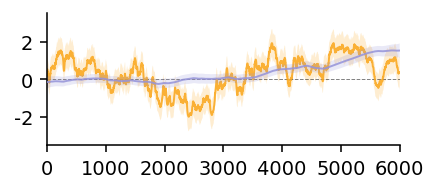

In [27]:
plt.figure(figsize=(3.25,1.25))
for i, c in enumerate(sim_colors):
    plt.plot(wMode[i], c=c, lw=1, linestyle='-', alpha=0.85, zorder=2*i+1)
    plt.fill_between(np.arange(len(wMode[i])), wMode[i] - 2 * W_std[i], wMode[i] + 2 * W_std[i],
                     facecolor=c, alpha=0.2, zorder=2*i)
    
plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)
plt.xticks(1000*np.arange(0,7))
plt.yticks(np.arange(-2,3,2))
plt.xlim(0,6000)
plt.ylim(-3.5,3.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

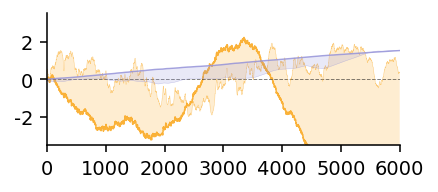

In [28]:
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((gen_dat['K'], -1), order="C")

noise = np.cumsum(E_rw, axis=1)
learning = np.cumsum(v_rw, axis=1)

plt.figure(figsize=(3.25,1.25))
for i, c in enumerate(sim_colors):
    plt.plot(learning[i], c=c, lw=0.75, linestyle='-', alpha=0.85, zorder=2*i)
    plt.fill_between(np.arange(len(noise[i])), learning[i], learning[i] + noise[i],
                     facecolor=c, alpha=0.2, zorder=2*i)
    plt.plot(learning[i] + noise[i], c=c, lw=0.25, linestyle='-', alpha=0.5, zorder=2*i+1)
    
plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)
plt.xticks(1000*np.arange(0,7))
plt.yticks(np.arange(-2,3,2))
plt.xlim(0,6000)
plt.ylim(-3.5,3.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Figure 4 | IBL Population Analysis

Figure 4 is a population level analysis that cannot be run locally in a reasonable amount of time. See the `cluster_scripts` directory for some files for running fitting in parallel on a cluster.

# Figure 5 | Reward Landscape

In [29]:
# Collect data from manually determined training period
outData = getMouse('CSHL_003', 5)
dat = psy.trim(outData, START=0, END=6000)

# Compute
weights = {'bias' : 1, 'cL' : 0, 'cR' : 0, 'cBoth': 1}
K = np.sum([weights[i] for i in weights.keys()])

In [30]:
# Compute
hyper_guess = {
    'alpha': [2**-6] * K,
    'sigma': [2**-4] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for both sigma and alpha simultaneously
optList = ['sigma', 'alpha']

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": dat, "K": K, "learning_rule": REINFORCE,
        "hyper": hyper_guess, "weights": weights, "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA')
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, weights, W0=None,
                                    learning_rule=rec_learning_rule, showOpt=0, tol=1e-12)
# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)
wMode = wMode.reshape((K, -1), order="C")

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, "W_std": W_std, "wMode": wMode}

    [-4. -4. -6. -6.] 1 3629.712 
    [-3. -4. -6. -6.] 2 3632.722 
    [-4. -3. -6. -6.] 3 3658.534 
    [-4. -4. -5. -6.] 4 3627.722 
    [-4. -4. -5. -5.] 5 3648.945 
    [-4.084 -4.801 -4.945 -6.59 ] 6 3616.883 
    [-4.223 -4.684 -4.853 -7.569] 7 3613.355 
    [-4.486 -5.559 -4.679 -7.936] 8 3611.783 
    [-4.71  -5.383 -3.728 -8.062] 9 3633.149 
    [-4.014 -5.649 -4.559 -8.003] 10 3603.402 
    [-3.336 -5.908 -5.174 -8.313] 11 3601.985 
    [-3.216 -6.135 -5.176 -7.883] 12 3606.035 
    [-3.405 -6.121 -5.113 -8.406] 13 3601.044 
    [-3.149 -6.089 -4.766 -8.657] 14 3601.307 
    [-3.639 -6.132 -5.275 -8.817] 15 3599.786 
    [-3.766 -6.541 -5.396 -9.043] 16 3600.077 
    [-3.816 -6.173 -5.132 -8.721] 17 3599.938 
    [-3.813 -5.834 -5.243 -9.178] 18 3600.213 
    [-3.687 -6.08  -5.477 -8.688] 19 3600.621 
    [-3.462 -6.174 -5.107 -8.852] 20 3599.583 
    [-3.501 -6.048 -5.029 -9.05 ] 21 3599.08 
    [-3.535 -6.207 -5.029 -9.24 ] 22 3598.677 
    [-3.521 -6.194 -4.962 -9.48 ] 23

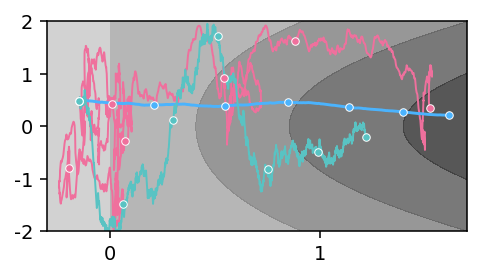

In [31]:
def get_prob_right(w_bias, w_stim, stim):
    return expit(w_bias + w_stim*stim)

def calculate_expected_reward(w_bias, w_stim):
    # Contrast vals considered
    contrast_vals = [-1.,  -0.98670389,  0.98670389, 1. ]
    # Assume each contrast occurs with equal frequency
    expected_reward = 0
    for contrast in contrast_vals:
        if contrast < 0:
            expected_reward += (1-get_prob_right(w_bias, w_stim, contrast))/len(contrast_vals)
        else:
            expected_reward += get_prob_right(w_bias, w_stim, contrast)/len(contrast_vals)
    return expected_reward


def simulate_data(mouse, W0, alpha,  seed):
    full_mouse_data = getMouse(mouse, 5)
    dat = psy.trim(full_mouse_data, END=6000)
    # Compute
    weights = {'bias': 1, 'cL': 0, 'cR': 0, 'cBoth': 1}
    K = np.sum([weights[i] for i in weights.keys()])

    X = psy.read_input(dat, weights)
    answer = dat["answer"]
    sigma = [0, 0]
    W, y, r, _ = simulate_learning(X=X, answer=answer, sigma=sigma, alpha=alpha,
                                   learning_rule=reinforce, W0 = W0, seed = seed)
    return W, y, r


N_bias = 200
N_contrast = 200
mouse = "CSHL_003"

fig, ax = plt.subplots(figsize=(3,1.5))

w_bias = np.linspace(-2.2, 2.2, N_bias)
w_contrast = np.linspace(-0.3,1.7, N_contrast)
xx, yy = np.meshgrid(w_bias, w_contrast)
z = np.zeros((N_bias, N_contrast))
for i, w_b in enumerate(w_bias):
    for j, w_c in enumerate(w_contrast):
        z[i, j] = calculate_expected_reward(w_b, w_c)
CS = plt.contourf(w_contrast,  w_bias,  z, levels = np.arange(0,11)/10,
                  cmap = 'Greys', alpha = 0.85, vmin = 0.2, vmax = 1)

N = len(wMode[0])
inc = np.arange(0,N+1000,1000)
inc[-1] = -1
jump = 3

plt.plot(wMode[1,::jump] ,wMode[0,::jump], lw = 1, color="#EF709D")
plt.scatter(wMode[1, inc], wMode[0, inc],
            color = "#EF709D", s=15, edgecolor='w', marker="o", zorder=10, lw=0.5)


# Simulate weight trajectory according to REINFORCE with single alpha retrieved from data
single_alpha = 0.0014743978688641268   # -- value of alpha when fitting above mouse with RF_1 
alpha = [single_alpha, single_alpha]
W_reinforce, _, _ = simulate_data(mouse, wMode[:,0], alpha, seed = 1)
plt.plot(W_reinforce[1,::jump] ,W_reinforce[0,::jump], lw = 1.5, color="#4BB3FD")
plt.scatter(W_reinforce[1, inc], W_reinforce[0, inc],
            color = "#4BB3FD", s=15, edgecolor='w', marker="o", zorder=10, lw=0.5)


# Simulate weight trajectory according to REINFORCE with multiple alpha retrieved from data
multiple_alpha = opt_hyper['alpha']
W_reinforce_mult_alpha, _, _ = simulate_data(mouse, wMode[:, 0], multiple_alpha, seed=1)

plt.plot(W_reinforce_mult_alpha[1,::jump] ,W_reinforce_mult_alpha[0,::jump], lw = 1, color=colors['c'])
plt.scatter(W_reinforce_mult_alpha[1, inc], W_reinforce_mult_alpha[0, inc],
            color = colors['c'], s=15, edgecolor='w', marker="o", zorder=10, lw=0.5)

plt.xticks(np.arange(0,2))
plt.yticks(np.arange(-2,3))
plt.xlim((-0.3, 1.7))
plt.ylim((-2, 2))
plt.subplots_adjust(0,0,1,1)

# Figure 6 | Example Athena Rat

Figure 3 runs two models, $[RF_0, RF_\beta]$ on an example rat (rat `W082` from the Akrami data). We show fitting for the $RF_1$ model here — the other models can be fit in an analogous way.

In [ ]:
orig_dat = getRat("W082")
dat = psy.trim(orig_dat, END=6000)

weights = {"bias": 1, "s_a": 1, "s_b": 1}
K = np.sum([i for i in weights.values()])

In [ ]:
# Compute
hyper_guess = {
    'alpha': 2**-6,
    'sigma': [2**-4] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for both sigma and alpha simultaneously
optList = ['sigma', 'alpha']

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": dat, "K": K, "learning_rule": REINFORCE,
        "hyper": hyper_guess, "weights": weights, "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA')
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, weights, W0=None,
                                    learning_rule=rec_learning_rule, showOpt=0, tol=1e-12)
# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)
wMode = wMode.reshape((K, -1), order="C")

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, "W_std": W_std, "wMode": wMode}

In [ ]:
sim_colors = [colors['bias'], colors['s_a'], colors['s_b']]

plt.figure(figsize=(3.25,1.25))
for i, c in enumerate(sim_colors):
    plt.plot(wMode[i], c=c, lw=1, linestyle='-', alpha=0.85, zorder=2*i+1)
    plt.fill_between(np.arange(len(wMode[i])), wMode[i] - 2 * W_std[i], wMode[i] + 2 * W_std[i],
                     facecolor=c, alpha=0.2, zorder=2*i)
    
plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)
plt.xticks(1000*np.arange(0,11))
plt.yticks(np.arange(-2,3,1))
plt.xlim(0,6000)
plt.ylim(-2.25,2.25)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

In [ ]:
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

noise = np.cumsum(E_rw, axis=1)
learning = np.cumsum(v_rw, axis=1)

plt.figure(figsize=(3.25,1.25))
for i, c in enumerate(sim_colors):
    plt.plot(learning[i], c=c, lw=0.75, linestyle='-', alpha=0.85, zorder=2*i)
    plt.fill_between(np.arange(len(noise[i])), learning[i], learning[i] + noise[i],
                     facecolor=c, alpha=0.2, zorder=2*i)
    plt.plot(learning[i] + noise[i], c=c, lw=0.25, linestyle='-', alpha=0.5, zorder=2*i+1)
    
plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)
plt.xticks(1000*np.arange(0,11))
plt.yticks(np.arange(-2,3,1))
plt.xlim(0,6000)
plt.ylim(-2.25,2.25)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

Plot recovery of weights and hyperparameters of R+B model

In [ ]:
### Set up
N = 6000  # would like to work with ~6000 trials, should try

seed = 22  # 20
print("Seed:", seed)
np.random.seed(seed)

# Simulate sequence of contrasts directly (instead of grabbing from real mouse)
p=5
contrasts = np.array([0.0625, 0.125, 0.25, 0.5, 1.0])  # full set of contrasts
tanh_contrasts = np.tanh(p*contrasts)/np.tanh(p)  # tanh transform
all_contrasts = np.hstack((-tanh_contrasts[::-1], [0], tanh_contrasts))  # left contrasts are neg

contrast_seq = np.random.choice(all_contrasts, size=N) # generate random sequence
answer = np.sign(contrast_seq).astype(int)  # infer answers for each trial
answer[answer==0] = np.sign(np.random.randn(np.sum(answer==0)))  # randomly select answer for 0 contrast
answer[answer<0] = 0

# Build data set from simulated data
weights = {"bias": 1, "cBoth": 1}
dat = {'inputs': {'cBoth': contrast_seq.reshape(-1,1)}, 'answer': answer, 'y': np.zeros(N)}
X = psy.read_input(dat, weights)
K = np.sum([i for i in weights.values()])

# Set true parameters of weight trajectory simulation
true_sigma  = 2**np.array([-5.0, -6.0])  # -5, -6
true_alpha  = 2**np.array([-6.0, -7.0])  # -6, -7
true_base  = np.array([-0.15, 0.1])  # -0.15, 0.1, careful about which parametrization is being used
true_hyper = {
    'adder': true_base,
    'alpha': true_alpha,
    'sigma': true_sigma,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

sim_learning_rule = reinforce_base  # learning rule used in generation of weights
rec_learning_rule = REINFORCE_base  # learning rule used for recovery of weights

# Simulate the weight trajectories, also returning choices and rewards
W, y, r, sim_noise = simulate_learning(X=X, answer=answer, sigma=true_sigma, sigma0=1, seed=seed,
                                       alpha=true_alpha, base=true_base/true_alpha, # NOTE
                                       learning_rule=sim_learning_rule)

dat.update({"y": y, "correct": r})
gen_dat = {"dat": dat, 'true_sigma': true_sigma, 'true_alpha': true_alpha, 'true_base': true_base,
           "weights": weights, "K": K,
           'sim_learning_rule': sim_learning_rule.__name__, "rec_learning_rule": rec_learning_rule.__name__,
           "W": W, "sim_noise": sim_noise, "seed": seed}
np.savez_compressed(spath+'FigN1_data2.npz', gen_dat=gen_dat)


# Display simulated weights, broken up into learning/nosie components
fig = psy.plot_weights(W, weights)

noise_sim = np.cumsum(gen_dat['sim_noise'].T, axis=1)
learning_sim = gen_dat['W'] - noise_sim

fig = plt.figure(figsize=(3.25,1.25))
sim_colors = [colors['bias'], colors['cBoth']]
for i, c in enumerate(sim_colors):
    plt.plot(learning_sim[i], c=c, lw=1, linestyle='-', alpha=0.75, zorder=1)
    plt.plot(noise_sim[i], c=c, lw=0.5, linestyle='--', alpha=0.5, zorder=2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 


# Calculate evdience under true hyper
wMode_true, _, logEvd, _ = getMAP(dat, true_hyper, weights, W0=None,
                         learning_rule=rec_learning_rule, showOpt=0, tol=1e-12)
print("True Evidence:", logEvd)
fig = psy.plot_weights(wMode_true.reshape(K,-1), weights)


In [ ]:
# gen_dat = np.load(spath+'FigN1_data2.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': [2**-7] * K,
    'sigma': [2**-4] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for sigma, alpha, and baseline (adder) simultaneously
optList = ['sigma', 'alpha', 'adder']

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": gen_dat['rec_learning_rule'],
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", logEvd)
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)


opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[gen_dat['rec_learning_rule']],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
# np.savez_compressed(spath+'FigN1_data2.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
H, g = compHess_nolog(evd_lossfun, res.x, 5e-2, {"keywords": args})  # try 5e-2 if you get nans
hyp_std = np.sqrt(np.diag(np.linalg.inv(H)))

rec_dat.update({'hyp_std': hyp_std})
# np.savez_compressed(spath+'FigN1_data2.npz', rec_dat=rec_dat, gen_dat=gen_dat)

print("Rec: ", res.x)
print("Std: ", hyp_std)

print("True:", np.log2(true_sigma), np.log2(true_alpha))
print(np.log2(2**res.x[:4] + hyp_std[:4]*1.96))
print(np.log2(2**res.x[:4] - hyp_std[:4]*1.96))

print("True:", true_base)
print(res.x[4:] + hyp_std[4:]*1.96)
print(res.x[4:] - hyp_std[4:]*1.96)

In [ ]:
print("Rec: ", res.x)
print("Std: ", hyp_std)

print("True:", np.log2(true_sigma), np.log2(true_alpha))
print(np.log2(2**res.x[:4] + hyp_std[:4]))
print(np.log2(2**res.x[:4] - hyp_std[:4]))

print("True:", true_base)
print(res.x[4:] + hyp_std[4:])
print(res.x[4:] - hyp_std[4:])

In [ ]:
# Reload data
# rec_dat = np.load(spath+'FigN1_data2.npz', allow_pickle=True)['rec_dat'].item()
# gen_dat = np.load(spath+'FigN1_data2.npz', allow_pickle=True)['gen_dat'].item()

# Plot recovered hyperparameters
plt.figure(figsize=(3.75,1.4))
sim_colors = [colors['bias'], colors['h']]
num_std = 1.00
K = gen_dat['K']


true_sigma = gen_dat['true_sigma']
avg_sigma = np.log2(rec_dat['opt_hyper']['sigma'])
err_sigma = rec_dat['hyp_std'][:K]
for i, c in enumerate(sim_colors):
    yerr = [[-(np.log2(2**avg_sigma[i] - err_sigma[i]*num_std) - avg_sigma[i])],
            [np.log2(2**avg_sigma[i] + err_sigma[i]*num_std) - avg_sigma[i]]]
    if np.isnan(yerr[0][0]):
        yerr[0][0] = 100
    plt.plot([i-0.3, i+0.3], [np.log2(true_sigma[i])]*2, color="black", linestyle="-", lw=1.2, zorder=1, alpha=0.4)
    plt.errorbar([i], avg_sigma[i], yerr=yerr, c=c, lw=1, marker='o', markersize=4)
    
true_alpha = gen_dat['true_alpha']
avg_alpha = np.log2(rec_dat['opt_hyper']['alpha'])
err_alpha = rec_dat['hyp_std'][K:2*K]
for i, c in enumerate(sim_colors):
    yerr = [[-(np.log2(2**avg_alpha[i] - err_alpha[i]*num_std) - avg_alpha[i])],
            [np.log2(2**avg_alpha[i] + err_alpha[i]*num_std) - avg_alpha[i]]]
    if np.isnan(yerr[0][0]):
        yerr[0][0] = 100
    plt.plot([i+1.7, i+2.3], [np.log2(true_alpha[i])]*2, color="black", linestyle="-", lw=1.2, zorder=1, alpha=0.4)
    plt.errorbar([i+2], avg_alpha[i], yerr=yerr, c=c, lw=1, marker='s', markersize=4)
    
plt.ylim(-8.5,-3.5)
plt.yticks(np.arange(-8,-3))
# plt.axvline(4, linestyle ='-', color="gray", lw=0.5)
plt.gca().spines['top'].set_visible(False)


ax2 = plt.twinx()
plt.sca(ax2)
true_base = gen_dat['true_base']
avg_base = rec_dat['opt_hyper']['adder']
err_base = rec_dat['hyp_std'][-K:]
for i, c in enumerate(sim_colors):
    plt.plot([i+4.7, i+5.3], [true_base[i]]*2, color="black", linestyle="-", lw=1.2, zorder=1, alpha=0.4)
    plt.errorbar([i+5], avg_base[i], yerr=num_std*err_base[i], c=c, lw=1, marker='^', markersize=4)

plt.xticks([0,1,2,3,5,6])
# plt.xlim(-0.5,3.5); 
plt.ylim(-0.25,0.25)

plt.gca().set_xticklabels([r"$\sigma_1$", r"$\sigma_2$",
                           r"$\alpha_1$", r"$\alpha_2$",
                           r"$\beta_1$", r"$\beta_2$"])

# plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 
plt.savefig(spath + "FigN1b.pdf")

In [ ]:
# Reload data
rec_dat = np.load(spath+'FigN1_data2.npz', allow_pickle=True)['rec_dat'].item()
gen_dat = np.load(spath+'FigN1_data2.npz', allow_pickle=True)['gen_dat'].item()

# Plotting
fig = plt.figure(figsize=(3.75,1.4))
sim_colors = [colors['bias'], colors['h']]

for i, c in enumerate(sim_colors):
    plt.plot(gen_dat['W'][i], c="black", lw=0.5, alpha=0.5, zorder=2*i)
    plt.plot(rec_dat['wMode'][i], c=c, lw=1, linestyle='-', alpha=0.85, zorder=2*i+1)
    plt.fill_between(np.arange(len(rec_dat['wMode'][i])),
                     rec_dat['wMode'][i] - 2 * rec_dat['W_std'][i],
                     rec_dat['wMode'][i] + 2 * rec_dat['W_std'][i],
                     facecolor=c, alpha=0.2, zorder=2*i+1)

plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)

# plt.xticks(1000*np.arange(0,11))
plt.gca().set_xticklabels([])
plt.yticks(np.arange(-4,5,2))

plt.xlim(0,len(gen_dat['W'][0])); plt.ylim(-5,5)
# plt.xlabel("Trials"); plt.ylabel("Weights")

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 
plt.savefig(spath + "FigN1a.pdf")

In [ ]:
# Reload data
# rec_dat = np.load(spath+'FigN1_data2.npz', allow_pickle=True)['rec_dat'].item()
# gen_dat = np.load(spath+'FigN1_data2.npz', allow_pickle=True)['gen_dat'].item()

noise = np.cumsum(rec_dat['E_rw'], axis=1)
learning = np.cumsum(rec_dat['v_rw'], axis=1)
noise_sim = np.cumsum(gen_dat['sim_noise'].T, axis=1)
learning_sim = gen_dat['W'] - noise_sim

fig = plt.figure(figsize=(3.75,1.4))

sim_colors = [colors['bias'], colors['cBoth']]
for i, c in enumerate(sim_colors):
    plt.plot(learning[i], c=c, lw=1.0, linestyle='-', alpha=0.85, zorder=10+2*i)
    plt.plot(learning_sim[i], c="black", lw=0.5, linestyle='-', alpha=0.25, zorder=2)
    plt.fill_between(np.arange(len(noise[i])),
                     learning[i], learning_sim[i],
                     facecolor="lightgray", alpha=0.25, zorder=1)

plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)

# plt.xticks(1000*np.arange(0,11))
plt.gca().set_xticklabels([])
plt.yticks(np.arange(-4,5,2))

plt.xlim(0,len(noise[i])); plt.ylim(-5,5)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.xlabel("Trials"); plt.ylabel("Weight\nComponents")

plt.subplots_adjust(0,0,1,1) 
plt.savefig(spath + "FigN1c.pdf")

In [ ]:
# Reload data
# rec_dat = np.load(spath+'FigN1_data2.npz', allow_pickle=True)['rec_dat'].item()
# gen_dat = np.load(spath+'FigN1_data2.npz', allow_pickle=True)['gen_dat'].item()

noise = np.cumsum(rec_dat['E_rw'], axis=1)
learning = np.cumsum(rec_dat['v_rw'], axis=1)
noise_sim = np.cumsum(gen_dat['sim_noise'].T, axis=1)
learning_sim = gen_dat['W'] - noise_sim

fig = plt.figure(figsize=(3.75,1.4))

sim_colors = [colors['bias'], colors['cBoth']]
for i, c in enumerate(sim_colors):
    plt.plot(noise[i], c=c, lw=1.0, linestyle='-', alpha=0.85, zorder=10+2*i+1)
    plt.plot(noise_sim[i], c="black", lw=0.5, linestyle='-', alpha=0.25, zorder=2)
    plt.fill_between(np.arange(len(noise[i])),
                     noise[i], noise_sim[i],
                     facecolor="lightgray", alpha=0.25, zorder=1)

plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)

# plt.xticks(1000*np.arange(0,11))
# plt.gca().set_xticklabels([0,1000,2000,3000,4000,5000])
plt.yticks(np.arange(-4,5,2))

plt.xlim(0,len(noise[i])); plt.ylim(-5,5)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.xlabel("Trials"); plt.ylabel("Weight\nComponents")

plt.subplots_adjust(0,0,1,1) 
plt.savefig(spath + "FigN1d.pdf")

## Figure S5

Evaluating model mismatch and recovery of the correct learning rule

Seed: 20
True Evidence: -2992.89550334886


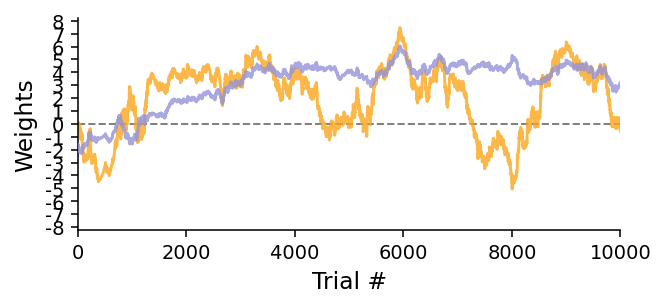

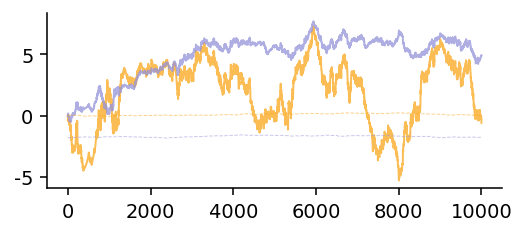

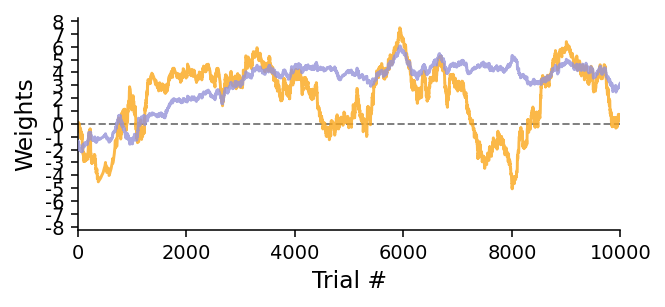

In [43]:
### Set up
N = 10000  # would like to work with ~6000 trials, should try

seed = 20  # 20
print("Seed:", seed)
np.random.seed(seed)

# Simulate sequence of contrasts directly (instead of grabbing from real mouse)
p=5
contrasts = np.array([0.0625, 0.125, 0.25, 0.5, 1.0])  # full set of contrasts
tanh_contrasts = np.tanh(p*contrasts)/np.tanh(p)  # tanh transform
all_contrasts = np.hstack((-tanh_contrasts[::-1], [0], tanh_contrasts))  # left contrasts are neg

contrast_seq = np.random.choice(all_contrasts, size=N) # generate random sequence
answer = np.sign(contrast_seq).astype(int)  # infer answers for each trial
answer[answer==0] = np.sign(np.random.randn(np.sum(answer==0)))  # randomly select answer for 0 contrast
answer[answer<0] = 0

# Build data set from simulated data
weights = {"bias": 1, "cBoth": 1}
dat = {'inputs': {'cBoth': contrast_seq.reshape(-1,1)}, 'answer': answer, 'y': np.zeros(N)}
X = psy.read_input(dat, weights)
K = np.sum([i for i in weights.values()])

# Set true parameters of weight trajectory simulation
true_sigma  = 2**np.array([-9.0, -9.0])  # -5, -6
true_alpha  = 2**np.array([-6.0, -7.0])  # -6, -7
true_base  = np.array([0.4, -0.2])  # -0.15, 0.1, careful about which parametrization is being used
true_hyper = {
    'adder': true_base,
    'alpha': true_alpha,
    'sigma': true_sigma,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

sim_learning_rule = reinforce_base  # learning rule used in generation of weights
rec_learning_rule = REINFORCE_base  # learning rule used for recovery of weights

# Simulate the weight trajectories, also returning choices and rewards
W, y, r, sim_noise = simulate_learning(X=X, answer=answer, sigma=true_sigma, sigma0=1, seed=seed,
                                       alpha=true_alpha, base=true_base/true_alpha, # NOTE
                                       learning_rule=sim_learning_rule)

dat.update({"y": y, "correct": r})
gen_dat = {"dat": dat, 'true_sigma': true_sigma, 'true_alpha': true_alpha, 'true_base': true_base,
           "weights": weights, "K": K,
           'sim_learning_rule': sim_learning_rule.__name__, "rec_learning_rule": rec_learning_rule.__name__,
           "W": W, "sim_noise": sim_noise, "seed": seed}
np.savez_compressed(spath+'FigN2_data.npz', gen_dat=gen_dat)


# Display simulated weights, broken up into learning/nosie components
fig = psy.plot_weights(W, weights)

noise_sim = np.cumsum(gen_dat['sim_noise'].T, axis=1)
learning_sim = gen_dat['W'] - noise_sim

fig = plt.figure(figsize=(3.25,1.25))
sim_colors = [colors['bias'], colors['cBoth']]
for i, c in enumerate(sim_colors):
    plt.plot(learning_sim[i], c=c, lw=1, linestyle='-', alpha=0.75, zorder=1)
    plt.plot(noise_sim[i], c=c, lw=0.5, linestyle='--', alpha=0.5, zorder=2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 


# Calculate evdience under true hyper
wMode_true, _, logEvd, _ = getMAP(dat, true_hyper, weights, W0=None,
                         learning_rule=rec_learning_rule, showOpt=0, tol=1e-12)
print("True Evidence:", logEvd)
fig = psy.plot_weights(wMode_true.reshape(K,-1), weights)


In [46]:
gen_dat = np.load(spath+'FigN2_data.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': [2**-7] * K,
    'sigma': [2**-16] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['alpha', 'adder']

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": gen_dat['rec_learning_rule'],
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA')
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[gen_dat['rec_learning_rule']],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
np.savez_compressed(spath+'FigN2_data.npz', rec_dat=rec_dat, gen_dat=gen_dat)


True Hyper: [-9. -9.] [-6. -7.] [ 0.4 -0.2]


TypeError: 'str' object is not callable

In [41]:
# Reload data
rec_dat = np.load(spath+'FigN2_data.npz', allow_pickle=True)['rec_dat'].item()
gen_dat = np.load(spath+'FigN2_data.npz', allow_pickle=True)['gen_dat'].item()

# Plotting
fig = plt.figure(figsize=(3.75,1.4))
sim_colors = [colors['bias'], colors['h']]

for i, c in enumerate(sim_colors):
    plt.plot(gen_dat['W'][i], c="black", lw=0.5, alpha=0.5, zorder=2*i)
    plt.plot(rec_dat['wMode'][i], c=c, lw=1, linestyle='-', alpha=0.85, zorder=2*i+1)
    plt.fill_between(np.arange(len(rec_dat['wMode'][i])),
                     rec_dat['wMode'][i] - 2 * rec_dat['W_std'][i],
                     rec_dat['wMode'][i] + 2 * rec_dat['W_std'][i],
                     facecolor=c, alpha=0.2, zorder=2*i+1)

plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)

# plt.xticks(1000*np.arange(0,11))
plt.gca().set_xticklabels([])
plt.yticks(np.arange(-8,9,2))

plt.xlim(0,len(gen_dat['W'][0])); plt.ylim(-7.5,7.5)
# plt.xlabel("Trials"); plt.ylabel("Weights")

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 
plt.savefig(spath + "FigN2a.pdf")

KeyError: 'rec_dat is not a file in the archive'

In [42]:
gen_dat = np.load(spath+'FigN2_data.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': [2**-7] * K,
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma', 'alpha', 'adder']

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": gen_dat['rec_learning_rule'],
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[gen_dat['rec_learning_rule']],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
np.savez_compressed(spath+'FigN2_data_b.npz', rec_dat=rec_dat, gen_dat=gen_dat)


True Hyper: [-9. -9.] [-6. -7.] [ 0.4 -0.2]


TypeError: 'str' object is not callable

In [ ]:
# Reload data
rec_dat = np.load(spath+'FigN2_data_b.npz', allow_pickle=True)['rec_dat'].item()
gen_dat = np.load(spath+'FigN2_data_b.npz', allow_pickle=True)['gen_dat'].item()

# Plotting
fig = plt.figure(figsize=(3.75,1.4))
sim_colors = [colors['bias'], colors['h']]

for i, c in enumerate(sim_colors):
    plt.plot(gen_dat['W'][i], c="black", lw=0.5, alpha=0.5, zorder=2*i)
    plt.plot(rec_dat['wMode'][i], c=c, lw=1, linestyle='-', alpha=0.85, zorder=2*i+1)
    plt.fill_between(np.arange(len(rec_dat['wMode'][i])),
                     rec_dat['wMode'][i] - 2 * rec_dat['W_std'][i],
                     rec_dat['wMode'][i] + 2 * rec_dat['W_std'][i],
                     facecolor=c, alpha=0.2, zorder=2*i+1)

plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)

# plt.xticks(1000*np.arange(0,11))
# plt.gca().set_xticklabels([])
plt.yticks(np.arange(-8,9,2))

plt.xlim(0,len(gen_dat['W'][0])); plt.ylim(-7.5,7.5)
# plt.xlabel("Trials"); plt.ylabel("Weights")

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 
plt.savefig(spath + "FigN2b.pdf")

Seed: 20
True Evidence: -4762.838398685446


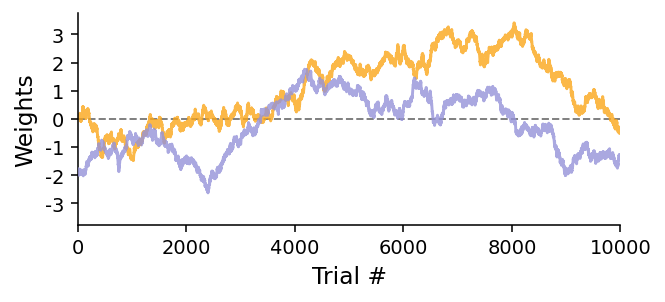

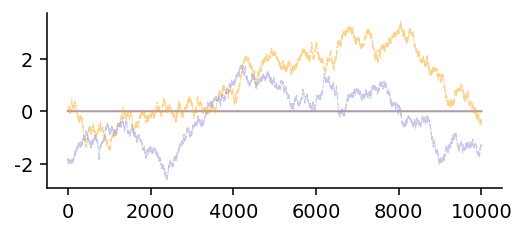

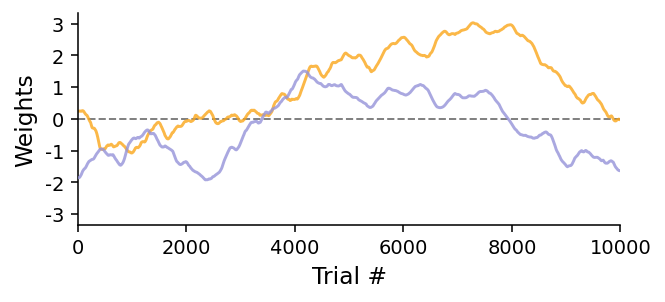

In [44]:
### Set up
N = 10000  # would like to work with ~6000 trials, should try

seed = 20  # 20
print("Seed:", seed)
np.random.seed(seed)

# Simulate sequence of contrasts directly (instead of grabbing from real mouse)
p=5
contrasts = np.array([0.0625, 0.125, 0.25, 0.5, 1.0])  # full set of contrasts
tanh_contrasts = np.tanh(p*contrasts)/np.tanh(p)  # tanh transform
all_contrasts = np.hstack((-tanh_contrasts[::-1], [0], tanh_contrasts))  # left contrasts are neg

contrast_seq = np.random.choice(all_contrasts, size=N) # generate random sequence
answer = np.sign(contrast_seq).astype(int)  # infer answers for each trial
answer[answer==0] = np.sign(np.random.randn(np.sum(answer==0)))  # randomly select answer for 0 contrast
answer[answer<0] = 0

# Build data set from simulated data
weights = {"bias": 1, "cBoth": 1}
dat = {'inputs': {'cBoth': contrast_seq.reshape(-1,1)}, 'answer': answer, 'y': np.zeros(N)}
X = psy.read_input(dat, weights)
K = np.sum([i for i in weights.values()])

# Set true parameters of weight trajectory simulation
true_sigma  = 2**np.array([-5.0, -5.0])  # -5, -6
true_alpha  = 2**np.array([-32.0, -32.0])  # -6, -7
true_base  = np.array([0.0, 0.0])  # -0.15, 0.1, careful about which parametrization is being used
true_hyper = {
    'adder': true_base,
    'alpha': true_alpha,
    'sigma': true_sigma,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

def no_learning(W, X, y, r, answer, i, base=None):
    pR = expit(X[i-1] @ W[i-1])
    return pR * (1-pR) * X[i-1] * (-1)**(answer[i-1]+1) / (1/2)

sim_learning_rule = no_learning  # learning rule used in generation of weights
rec_learning_rule = None  # learning rule used for recovery of weights

# Simulate the weight trajectories, also returning choices and rewards
W, y, r, sim_noise = simulate_learning(X=X, answer=answer, sigma=true_sigma, sigma0=1, seed=seed,
                                       alpha=true_alpha, base=true_base/true_alpha, # NOTE
                                       learning_rule=sim_learning_rule)

dat.update({"y": y, "correct": r})
gen_dat = {"dat": dat, 'true_sigma': true_sigma, 'true_alpha': true_alpha, 'true_base': true_base,
           "weights": weights, "K": K,
           'sim_learning_rule': sim_learning_rule.__name__, 
           "W": W, "sim_noise": sim_noise, "seed": seed}
np.savez_compressed(spath+'FigN3_data.npz', gen_dat=gen_dat)


# Display simulated weights, broken up into learning/nosie components
fig = psy.plot_weights(W, weights)

noise_sim = np.cumsum(gen_dat['sim_noise'].T, axis=1)
learning_sim = gen_dat['W'] - noise_sim

fig = plt.figure(figsize=(3.25,1.25))
sim_colors = [colors['bias'], colors['cBoth']]
for i, c in enumerate(sim_colors):
    plt.plot(learning_sim[i], c=c, lw=1, linestyle='-', alpha=0.75, zorder=1)
    plt.plot(noise_sim[i], c=c, lw=0.5, linestyle='--', alpha=0.5, zorder=2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 


# Calculate evdience under true hyper
wMode_true, _, logEvd, _ = getMAP(dat, true_hyper, weights, W0=None,
                         learning_rule=rec_learning_rule, showOpt=0, tol=1e-12)
print("True Evidence:", logEvd)
fig = psy.plot_weights(wMode_true.reshape(K,-1), weights)


In [45]:
gen_dat = np.load(spath+'FigN3_data.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma']

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": None,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=None,
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode}
np.savez_compressed(spath+'FigN3_data_a1.npz', rec_dat=rec_dat, gen_dat=gen_dat)


True Hyper: [-5. -5.] [-32. -32.] [0. 0.]
    [-5. -5.] 1 4762.838 
    [-4. -5.] 2 4779.077 
    [-5. -4.] 3 4770.632 
    [-5.902 -5.433] 4 4773.177 
    [-5.451 -5.216] 5 4765.202 
    [-4.811 -5.164] 6 4764.379 
    [-4.988 -4.75 ] 7 4762.844 
    [-5.125 -4.994] 8 4762.732 
    [-5.25  -4.992] 9 4763.01 
    [-5.128 -5.057] 10 4762.914 
    [-5.155 -4.873] 11 4762.623 
    [-5.037 -4.829] 12 4762.627 
    [-5.203 -4.758] 13 4762.848 
    [-5.134 -4.932] 14 4762.632 
    [-5.172 -4.847] 15 4762.659 
    [-5.125 -4.862] 16 4762.59 
    [-5.096 -4.873] 17 4762.575 
    [-5.075 -4.85 ] 18 4762.583 
    [-5.089 -4.887] 19 4762.578 
    [-5.104 -4.873] 20 4762.577 
    [-5.091 -4.866] 21 4762.575 
    [-5.088 -4.869] 22 4762.575 
    [-5.092 -4.863] 23 4762.576 
    [-5.093 -4.868] 24 4762.575 
    [-5.094 -4.869] 25 4762.575 
    [-5.095 -4.869] 26 4762.575 
    [-5.093 -4.871] 27 4762.575 
    [-5.091 -4.872] 28 4762.575 
    [-5.092 -4.872] 29 4762.575 
    [-5.093 -4.871] 30 4762.57

In [ ]:
gen_dat = np.load(spath+'FigN3_data.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': 2**-7,
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma', 'alpha']
lr = "REINFORCE"

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": lr,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[lr],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
np.savez_compressed(spath+'FigN3_data_a2.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
gen_dat = np.load(spath+'FigN3_data.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': [2**-7] * K,
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma', 'alpha']
lr = "REINFORCE"

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": lr,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[lr],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
np.savez_compressed(spath+'FigN3_data_a3.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
gen_dat = np.load(spath+'FigN3_data.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': [2**-7] * K,
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma', 'alpha', 'adder']
lr = "REINFORCE_base"

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": lr,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[lr],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
np.savez_compressed(spath+'FigN3_data_a4.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
### Set up
N = 10000  # would like to work with ~6000 trials, should try

seed = 20  # 20
print("Seed:", seed)
np.random.seed(seed)

# Simulate sequence of contrasts directly (instead of grabbing from real mouse)
p=5
contrasts = np.array([0.0625, 0.125, 0.25, 0.5, 1.0])  # full set of contrasts
tanh_contrasts = np.tanh(p*contrasts)/np.tanh(p)  # tanh transform
all_contrasts = np.hstack((-tanh_contrasts[::-1], [0], tanh_contrasts))  # left contrasts are neg

contrast_seq = np.random.choice(all_contrasts, size=N) # generate random sequence
answer = np.sign(contrast_seq).astype(int)  # infer answers for each trial
answer[answer==0] = np.sign(np.random.randn(np.sum(answer==0)))  # randomly select answer for 0 contrast
answer[answer<0] = 0

# Build data set from simulated data
weights = {"bias": 1, "cBoth": 1}
dat = {'inputs': {'cBoth': contrast_seq.reshape(-1,1)}, 'answer': answer, 'y': np.zeros(N)}
X = psy.read_input(dat, weights)
K = np.sum([i for i in weights.values()])

# Set true parameters of weight trajectory simulation
true_sigma  = 2**np.array([-5.0, -5.0])  # -5, -6
true_alpha  = 2**np.array([-7.0])  # -6, -7
true_base  = np.array([0.0, 0.0])  # -0.15, 0.1, careful about which parametrization is being used
true_hyper = {
    'adder': true_base,
    'alpha': true_alpha,
    'sigma': true_sigma,
    'sigInit': [2**4] * K,
    'sigDay': None,
}


sim_learning_rule = reinforce  # learning rule used in generation of weights
rec_learning_rule = REINFORCE  # learning rule used for recovery of weights

# Simulate the weight trajectories, also returning choices and rewards
W, y, r, sim_noise = simulate_learning(X=X, answer=answer, sigma=true_sigma, sigma0=1, seed=seed,
                                       alpha=true_alpha, base=true_base/true_alpha, # NOTE
                                       learning_rule=sim_learning_rule)

dat.update({"y": y, "correct": r})
gen_dat = {"dat": dat, 'true_sigma': true_sigma, 'true_alpha': true_alpha, 'true_base': true_base,
           "weights": weights, "K": K,
           'sim_learning_rule': sim_learning_rule.__name__, 'rec_learning_rule': rec_learning_rule.__name__,
           "W": W, "sim_noise": sim_noise, "seed": seed}
np.savez_compressed(spath+'FigN3_data_b.npz', gen_dat=gen_dat)


# Display simulated weights, broken up into learning/nosie components
fig = psy.plot_weights(W, weights)

noise_sim = np.cumsum(gen_dat['sim_noise'].T, axis=1)
learning_sim = gen_dat['W'] - noise_sim

fig = plt.figure(figsize=(3.25,1.25))
sim_colors = [colors['bias'], colors['cBoth']]
for i, c in enumerate(sim_colors):
    plt.plot(learning_sim[i], c=c, lw=1, linestyle='-', alpha=0.75, zorder=1)
    plt.plot(noise_sim[i], c=c, lw=0.5, linestyle='--', alpha=0.5, zorder=2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 


# Calculate evdience under true hyper
wMode_true, _, logEvd, _ = getMAP(dat, true_hyper, weights, W0=None,
                         learning_rule=rec_learning_rule, showOpt=0, tol=1e-12)
print("True Evidence:", logEvd)
fig = psy.plot_weights(wMode_true.reshape(K,-1), weights)


In [ ]:
gen_dat = np.load(spath+'FigN3_data_b.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma']

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": None,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=None,
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode}
np.savez_compressed(spath+'FigN3_data_b1.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
gen_dat = np.load(spath+'FigN3_data_b.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': 2**-7,
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma', 'alpha']
lr = "REINFORCE"

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": lr,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[lr],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
np.savez_compressed(spath+'FigN3_data_b2.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
gen_dat = np.load(spath+'FigN3_data_b.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': [2**-7] * K,
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma', 'alpha']
lr = "REINFORCE"

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": lr,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[lr],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
np.savez_compressed(spath+'FigN3_data_b3.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
gen_dat = np.load(spath+'FigN3_data_b.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': [2**-7] * K,
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma', 'alpha', 'adder']
lr = "REINFORCE_base"

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": lr,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[lr],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
np.savez_compressed(spath+'FigN3_data_b4.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
### Set up
N = 10000  # would like to work with ~6000 trials, should try

seed = 20  # 20
print("Seed:", seed)
np.random.seed(seed)

# Simulate sequence of contrasts directly (instead of grabbing from real mouse)
p=5
contrasts = np.array([0.0625, 0.125, 0.25, 0.5, 1.0])  # full set of contrasts
tanh_contrasts = np.tanh(p*contrasts)/np.tanh(p)  # tanh transform
all_contrasts = np.hstack((-tanh_contrasts[::-1], [0], tanh_contrasts))  # left contrasts are neg

contrast_seq = np.random.choice(all_contrasts, size=N) # generate random sequence
answer = np.sign(contrast_seq).astype(int)  # infer answers for each trial
answer[answer==0] = np.sign(np.random.randn(np.sum(answer==0)))  # randomly select answer for 0 contrast
answer[answer<0] = 0

# Build data set from simulated data
weights = {"bias": 1, "cBoth": 1}
dat = {'inputs': {'cBoth': contrast_seq.reshape(-1,1)}, 'answer': answer, 'y': np.zeros(N)}
X = psy.read_input(dat, weights)
K = np.sum([i for i in weights.values()])

# Set true parameters of weight trajectory simulation
true_sigma  = 2**np.array([-5.0, -5.0])  # -5, -6
true_alpha  = 2**np.array([-5.0, -9.0])  # -6, -7
true_base  = np.array([0.0, 0.0])  # -0.15, 0.1, careful about which parametrization is being used
true_hyper = {
    'adder': true_base,
    'alpha': true_alpha,
    'sigma': true_sigma,
    'sigInit': [2**4] * K,
    'sigDay': None,
}


sim_learning_rule = reinforce  # learning rule used in generation of weights
rec_learning_rule = REINFORCE  # learning rule used for recovery of weights

# Simulate the weight trajectories, also returning choices and rewards
W, y, r, sim_noise = simulate_learning(X=X, answer=answer, sigma=true_sigma, sigma0=1, seed=seed,
                                       alpha=true_alpha, base=true_base/true_alpha, # NOTE
                                       learning_rule=sim_learning_rule)

dat.update({"y": y, "correct": r})
gen_dat = {"dat": dat, 'true_sigma': true_sigma, 'true_alpha': true_alpha, 'true_base': true_base,
           "weights": weights, "K": K,
           'sim_learning_rule': sim_learning_rule.__name__, 'rec_learning_rule': rec_learning_rule.__name__,
           "W": W, "sim_noise": sim_noise, "seed": seed}
np.savez_compressed(spath+'FigN3_data_c.npz', gen_dat=gen_dat)


# Display simulated weights, broken up into learning/nosie components
fig = psy.plot_weights(W, weights)

noise_sim = np.cumsum(gen_dat['sim_noise'].T, axis=1)
learning_sim = gen_dat['W'] - noise_sim

fig = plt.figure(figsize=(3.25,1.25))
sim_colors = [colors['bias'], colors['cBoth']]
for i, c in enumerate(sim_colors):
    plt.plot(learning_sim[i], c=c, lw=1, linestyle='-', alpha=0.75, zorder=1)
    plt.plot(noise_sim[i], c=c, lw=0.5, linestyle='--', alpha=0.5, zorder=2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 


# Calculate evdience under true hyper
wMode_true, _, logEvd, _ = getMAP(dat, true_hyper, weights, W0=None,
                         learning_rule=rec_learning_rule, showOpt=0, tol=1e-12)
print("True Evidence:", logEvd)
fig = psy.plot_weights(wMode_true.reshape(K,-1), weights)


In [ ]:
gen_dat = np.load(spath+'FigN3_data_c.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma']

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": None,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=None,
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode}
np.savez_compressed(spath+'FigN3_data_c1.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
gen_dat = np.load(spath+'FigN3_data_c.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': 2**-7,
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma', 'alpha']
lr = "REINFORCE"

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": lr,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[lr],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
np.savez_compressed(spath+'FigN3_data_c2.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
gen_dat = np.load(spath+'FigN3_data_c.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': [2**-7] * K,
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma', 'alpha']
lr = "REINFORCE"

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": lr,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[lr],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
np.savez_compressed(spath+'FigN3_data_c3.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
gen_dat = np.load(spath+'FigN3_data_c.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': [2**-7] * K,
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma', 'alpha', 'adder']
lr = "REINFORCE_base"

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": lr,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[lr],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
np.savez_compressed(spath+'FigN3_data_c4.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
### Set up
N = 10000  # would like to work with ~6000 trials, should try

seed = 20  # 20
print("Seed:", seed)
np.random.seed(seed)

# Simulate sequence of contrasts directly (instead of grabbing from real mouse)
p=5
contrasts = np.array([0.0625, 0.125, 0.25, 0.5, 1.0])  # full set of contrasts
tanh_contrasts = np.tanh(p*contrasts)/np.tanh(p)  # tanh transform
all_contrasts = np.hstack((-tanh_contrasts[::-1], [0], tanh_contrasts))  # left contrasts are neg

contrast_seq = np.random.choice(all_contrasts, size=N) # generate random sequence
answer = np.sign(contrast_seq).astype(int)  # infer answers for each trial
answer[answer==0] = np.sign(np.random.randn(np.sum(answer==0)))  # randomly select answer for 0 contrast
answer[answer<0] = 0

# Build data set from simulated data
weights = {"bias": 1, "cBoth": 1}
dat = {'inputs': {'cBoth': contrast_seq.reshape(-1,1)}, 'answer': answer, 'y': np.zeros(N)}
X = psy.read_input(dat, weights)
K = np.sum([i for i in weights.values()])

# Set true parameters of weight trajectory simulation
true_sigma  = 2**np.array([-5.0, -5.0])  # -5, -6
true_alpha  = 2**np.array([-5.0, -9.0])  # -6, -7
true_base  = np.array([0.2, -0.2])  # -0.15, 0.1, careful about which parametrization is being used
true_hyper = {
    'adder': true_base,
    'alpha': true_alpha,
    'sigma': true_sigma,
    'sigInit': [2**4] * K,
    'sigDay': None,
}


sim_learning_rule = reinforce_base  # learning rule used in generation of weights
rec_learning_rule = REINFORCE_base  # learning rule used for recovery of weights

# Simulate the weight trajectories, also returning choices and rewards
W, y, r, sim_noise = simulate_learning(X=X, answer=answer, sigma=true_sigma, sigma0=1, seed=seed,
                                       alpha=true_alpha, base=true_base/true_alpha, # NOTE
                                       learning_rule=sim_learning_rule)

dat.update({"y": y, "correct": r})
gen_dat = {"dat": dat, 'true_sigma': true_sigma, 'true_alpha': true_alpha, 'true_base': true_base,
           "weights": weights, "K": K,
           'sim_learning_rule': sim_learning_rule.__name__, 'rec_learning_rule': rec_learning_rule.__name__,
           "W": W, "sim_noise": sim_noise, "seed": seed}
np.savez_compressed(spath+'FigN3_data_d.npz', gen_dat=gen_dat)


# Display simulated weights, broken up into learning/nosie components
fig = psy.plot_weights(W, weights)

noise_sim = np.cumsum(gen_dat['sim_noise'].T, axis=1)
learning_sim = gen_dat['W'] - noise_sim

fig = plt.figure(figsize=(3.25,1.25))
sim_colors = [colors['bias'], colors['cBoth']]
for i, c in enumerate(sim_colors):
    plt.plot(learning_sim[i], c=c, lw=1, linestyle='-', alpha=0.75, zorder=1)
    plt.plot(noise_sim[i], c=c, lw=0.5, linestyle='--', alpha=0.5, zorder=2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.subplots_adjust(0,0,1,1) 


# Calculate evdience under true hyper
wMode_true, _, logEvd, _ = getMAP(dat, true_hyper, weights, W0=None,
                         learning_rule=rec_learning_rule, showOpt=0, tol=1e-12)
print("True Evidence:", logEvd)
fig = psy.plot_weights(wMode_true.reshape(K,-1), weights)


In [ ]:
gen_dat = np.load(spath+'FigN3_data_d.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma']

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": None,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=None,
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode}
np.savez_compressed(spath+'FigN3_data_d1.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
gen_dat = np.load(spath+'FigN3_data_d.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': 2**-7,
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma', 'alpha']
lr = "REINFORCE"

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": lr,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[lr],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
np.savez_compressed(spath+'FigN3_data_d2.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
gen_dat = np.load(spath+'FigN3_data_d.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': [2**-7] * K,
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma', 'alpha']
lr = "REINFORCE"

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": lr,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[lr],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
np.savez_compressed(spath+'FigN3_data_d3.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
gen_dat = np.load(spath+'FigN3_data_d.npz', allow_pickle=True)['gen_dat'].item()

K = gen_dat['K']
hyper_guess = {
    'adder': [0.0] * K,
    'alpha': [2**-7] * K,
    'sigma': [2**-5] * K,
    'sigInit': [2**4] * K,
    'sigDay': None,
}

# Optimizing for alpha and baseline (adder) simultaneously
optList = ['sigma', 'alpha', 'adder']
lr = "REINFORCE_base"

# List of extra arguments used by evd_lossfun in optimization of evidence
args = {"optList": optList, "dat": gen_dat['dat'], "K": K, "learning_rule": lr,
        "hyper": hyper_guess, "weights": gen_dat['weights'], "update_w": True, "wMode": None,
        "tol": 1e-6, "showOpt": True,
       }
options = {'maxiter': 1e5}

# Optimization, can also use Nelder-Mead but COBYLA is fastest and pretty reliable
print("True Hyper:", np.log2(gen_dat['true_sigma']), np.log2(gen_dat['true_alpha']), gen_dat['true_base'])
# print("True Evidence:", gen_dat['logEvd'])
res = minimize(evd_lossfun, hyper_to_list(hyper_guess, optList, K), args=args, method='COBYLA', options=options)
print("Evidence:", -res.fun, "  ", optList, ": ", res.x)

opt_hyper = update_hyper(res.x, optList, hyper_guess, K)

# Recover weights from optimal hyper
wMode, Hess, logEvd, other = getMAP(dat, opt_hyper, gen_dat['weights'], W0=None,
                                    learning_rule=globals()[lr],
                                    showOpt=0, tol=1e-12)

wMode = wMode.reshape((K, -1), order="C")
v_rw = other['pT']['learning_terms']['v'].T
E_rw = other['pT']['learning_terms']["E_flat"].reshape((K, -1), order="C")

# Recover error bars for weights
W_std = getCredibleInterval(Hess, K)

rec_dat = {"args": args, 'res': res, 'opt_hyper': opt_hyper, 'logEvd': logEvd,
           "W_std": W_std, "wMode": wMode, 'v_rw': v_rw, 'E_rw': E_rw}
np.savez_compressed(spath+'FigN3_data_d4.npz', rec_dat=rec_dat, gen_dat=gen_dat)


In [ ]:
sim_colors = [colors['bias'], colors['h']]
fig, axs = plt.subplots(4,4,sharex=False,sharey=False,figsize=(5, 2))

def standard_adjust(ax):
    plt.sca(ax)
    plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)
    plt.xticks(1000*np.arange(0,11,2))
    plt.gca().set_xticklabels([])
    plt.yticks(np.arange(-6,9,3))
    plt.gca().set_yticklabels([])
    plt.xlim(0,10000)
    plt.ylim(-6.5,6.5)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.setp(ax.spines.values(), linewidth=0.5)
    plt.setp(ax.xaxis.get_ticklines(), 'markeredgewidth', 0.5)
    plt.setp(ax.yaxis.get_ticklines(), 'markeredgewidth', 0.5)

    

sim_paths = ['a', 'b', 'c', 'd']
rec_paths = ['1', '2', '3', '4']

for k in range(4):
    for j in range(4):
        # Reload data
        rec_dat = np.load(spath+'FigN3_data_'+sim_paths[k]+rec_paths[j]+'.npz', allow_pickle=True)['rec_dat'].item()
        gen_dat = np.load(spath+'FigN3_data_'+sim_paths[k]+rec_paths[j]+'.npz', allow_pickle=True)['gen_dat'].item()

        # Plotting
        plt.sca(axs[k,j])

        for i, c in enumerate(sim_colors):
            plt.plot(gen_dat['W'][i], c="black", lw=0.5, alpha=0.5, zorder=2*i)
            plt.plot(rec_dat['wMode'][i], c=c, lw=1, linestyle='-', alpha=0.85, zorder=2*i+1)
            plt.fill_between(np.arange(len(rec_dat['wMode'][i])),
                             rec_dat['wMode'][i] - 2 * rec_dat['W_std'][i],
                             rec_dat['wMode'][i] + 2 * rec_dat['W_std'][i],
                             facecolor=c, alpha=0.2, zorder=2*i+1)
        standard_adjust(plt.gca())
        
        if k != 3:
            plt.xticks([])
        if j != 0:
            plt.yticks([])
            
        if k == j:
            axs[k,j].set_facecolor("#f2f2f2")
            
#         if k==3 and j==0:
#             plt.gca().set_xticklabels([0, None, None, None, None,10000])
#             plt.gca().set_yticklabels([-6,None,0,None,6])

        
plt.subplots_adjust(0,0,1,1, wspace=0.05, hspace=0.1)
plt.savefig(spath + "FigN3a.pdf")

# axs[0,1].remove()

In [ ]:
# Reload data
rec_dat = np.load(spath+'FigN1_data.npz', allow_pickle=True)['rec_dat'].item()
gen_dat = np.load(spath+'FigN1_data.npz', allow_pickle=True)['gen_dat'].item()

noise = np.cumsum(rec_dat['E_rw'], axis=1)
learning = np.cumsum(rec_dat['v_rw'], axis=1)
noise_sim = np.cumsum(gen_dat['sim_noise'].T, axis=1)
learning_sim = gen_dat['W'] - noise_sim

fig = plt.figure(figsize=(3.75,1.4))

sim_colors = [colors['bias'], colors['cBoth']]
for i, c in enumerate(sim_colors):
    plt.plot(learning[i], c=c, lw=1.0, linestyle='-', alpha=0.85, zorder=10+2*i)
    plt.plot(learning_sim[i], c="black", lw=0.5, linestyle='-', alpha=0.25, zorder=2)
    plt.fill_between(np.arange(len(noise[i])),
                     learning[i], learning_sim[i],
                     facecolor="lightgray", alpha=0.25, zorder=1)

plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)

# plt.xticks(1000*np.arange(0,11))
plt.gca().set_xticklabels([])
plt.yticks(np.arange(-4,5,2))

plt.xlim(0,len(noise[i])); plt.ylim(-5,5)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.xlabel("Trials"); plt.ylabel("Weight\nComponents")

plt.subplots_adjust(0,0,1,1) 
plt.savefig(spath + "FigN1c.pdf")

In [ ]:
sim_colors = [colors['bias'], colors['h']]
fig, axs = plt.subplots(4,4,sharex=False,sharey=False,figsize=(5, 2))

def standard_adjust(ax):
    plt.sca(ax)
    plt.axhline(0, color="black", linestyle="--", lw=0.5, alpha=0.5, zorder=0)
    plt.xticks(1000*np.arange(0,11,2))
    plt.gca().set_xticklabels([])
    plt.yticks(np.arange(-6,9,3))
    plt.gca().set_yticklabels([])
    plt.xlim(0,10000)
    plt.ylim(-6.5,6.5)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.setp(ax.spines.values(), linewidth=0.5)
    plt.setp(ax.xaxis.get_ticklines(), 'markeredgewidth', 0.5)
    plt.setp(ax.yaxis.get_ticklines(), 'markeredgewidth', 0.5)

    

sim_paths = ['a', 'b', 'c', 'd']
rec_paths = ['1', '2', '3', '4']

for k in range(4):
    for j in range(4):
        
        if j==0:
            axs[k,j].remove()
            continue
        # Reload data
        rec_dat = np.load(spath+'FigN3_data_'+sim_paths[k]+rec_paths[j]+'.npz', allow_pickle=True)['rec_dat'].item()
        gen_dat = np.load(spath+'FigN3_data_'+sim_paths[k]+rec_paths[j]+'.npz', allow_pickle=True)['gen_dat'].item()

        noise = np.cumsum(rec_dat['E_rw'], axis=1)
        learning = np.cumsum(rec_dat['v_rw'], axis=1)
        noise_sim = np.cumsum(gen_dat['sim_noise'].T, axis=1)
        learning_sim = gen_dat['W'] - noise_sim

        # Plotting
        plt.sca(axs[k,j])

        for i, c in enumerate(sim_colors):
            plt.plot(learning[i], c=c, lw=1.0, linestyle='-', alpha=0.85, zorder=10+2*i)
            plt.plot(learning_sim[i], c="black", lw=0.5, linestyle='-', alpha=0.25, zorder=2)
            plt.fill_between(np.arange(len(noise[i])),
                             learning[i], learning_sim[i],
                             facecolor="lightgray", alpha=0.25, zorder=1)
        standard_adjust(plt.gca())
        
        if k != 3:
            plt.xticks([])
        if j != 1:
            plt.yticks([])
            
        if k == j:
            axs[k,j].set_facecolor("#f2f2f2")
            
#         if k==3 and j==1:
#             plt.gca().set_xticklabels([0, None, None, None, None,10000])
#             plt.gca().set_yticklabels([-6,None,0,None,6])

        
plt.subplots_adjust(0,0,1,1, wspace=0.05, hspace=0.1)
plt.savefig(spath + "FigN3b.pdf")



In [ ]:
def calculate_aic(logEvd, k):
    aic = 2*k + 2*logEvd
    return aic

plt.figure(figsize=(2,1))

sim_paths = ['a', 'b', 'c', 'd']
rec_paths = ['1', '2', '3', '4']
ks = [2,3,4,6]
mycolors = ["red", "blue", "green", "purple"]
mycolors = [psy.COLORS['s1'], psy.COLORS['s_avg'], psy.COLORS['c'], psy.COLORS['s2']]
myls = ["-", "--", ":", "-."]

for k in range(4):
    model_aic = []
    for j in range(4):
        rec_dat = np.load(spath+'FigN3_data_'+sim_paths[k]+rec_paths[j]+'.npz', allow_pickle=True)['rec_dat'].item()
        model_aic += [calculate_aic(-rec_dat['logEvd'], ks[j])]
    
    model_aic = np.array(model_aic) - model_aic[k]
    plt.plot(model_aic, color=mycolors[k], alpha=1.0, label=str(k), marker='o', markersize=2.5, ls='-', lw=0.75)
    plt.scatter([k], model_aic[k], marker="o", edgecolor=mycolors[k], color="white", s=20, zorder=100, lw=0.75)

plt.plot([-5,3], [0,0], color="black", linestyle=":", lw=1.0, alpha=0.6, zorder=0)
plt.xticks(np.arange(0,4,1))
plt.gca().set_xticklabels([])
plt.yticks(np.arange(0,20,5))
# plt.gca().set_yticklabels([])
plt.xlim(-0.08,3.08)
plt.ylim(-1,15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
    
plt.subplots_adjust(0,0,1,1)
plt.savefig(spath + "FigN3c.pdf")



## Figures S7-10

Figures S7-10 are analyses of entire populations that cannot be run locally in a reasonable amount of time. See the `cluster_scripts` directory for some files for running fitting in parallel on a cluster.